In [1]:
import h2o
from h2o.automl import H2OAutoML

import subprocess
#subprocess.run('unset http_proxy', shell=True)

#h2o.init(ip="localhost", port=54321, bind_to_localhost=True)
h2o.init()

import findspark
findspark.init()

import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types

sc = pyspark.SparkContext(appName="phishingURL-AUTOML-BestModel-Discovery")
sqlContext = SQLContext(sc)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_172"; Java(TM) SE Runtime Environment (build 1.8.0_172-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.172-b11, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-5.1.0.1/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpasakro4z
  JVM stdout: /tmp/tmpasakro4z/h2o_siemanalyst_started_from_python.out
  JVM stderr: /tmp/tmpasakro4z/h2o_siemanalyst_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_siemanalyst_icvpxz
H2O cluster total nodes:,1
H2O cluster free memory:,5.176 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [2]:
sc.stop()

In [4]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType 
from pyspark.sql.types import StructField
from pyspark.sql.types import StructType 
from pyspark.sql.types import ArrayType

from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy import stats

## URL count(".com") function6.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())
#print(func_count_dot_com("http://www.sapo.pt.com.test.com"))


## URL KL from URL TO English Language function7.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
    # Validate if Diverge
    def yn_diverge(n):
        return 1 if n< 0.0 else 0

    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    out_divergence=KL(values1,values2)
    # Validate Divergence is bad y/n
    val_yndiverge = yn_diverge(out_divergence)
    return (out_divergence,val_yndiverge)
schema7 = ArrayType(StructType([StructField("kldivergence", FloatType(), False),StructField("ynkldiverge", IntegerType(), False)]))
func_kl_en_url_udf = udf(func_kl_en_url, schema7)

result=func_kl_en_url("https://www.google.com")
print(result)
# 0.0

result=func_kl_en_url("https://10.12.61.1/bug")
print(result)
# -330.2231122802843


## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):

        # Validate if Diverge
    def yn_low_pvalue(n):
        return 1 if n< 1.0 else 0
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue = np.asscalar(pvalue)
    ynkspvalue = yn_low_pvalue(scalar_pvalue)
    return (scalar_pvalue,ynkspvalue) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
schema8 = ArrayType(StructType([StructField("kspvalue", FloatType(), False),StructField("ynkspvalue", IntegerType(), False)]))
func_ks_en_url_udf = udf(func_ks_en_url, schema8)

print(func_ks_en_url("http://www.google.com"))
#
#[ 46  46  99 101 103 103 108 109 111 111 111 119 119 119]
#[ 46  46  97  99 100 101 102 109 110 111 111 112 114 122]
# 1.0

print(func_ks_en_url("https://10.12.61.1/-b-u-g-"))
# 0.0029651946233535


(0.0, 0)
(-330.2231122802843, 1)
(1.0, 0)
(0.00028465698642661904, 1)


In [55]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import explode
from pyspark.sql.functions import *
from scipy.stats import kstest


## ynverified=1/0 as phishing
## To be discovered with ML/DL/CNN
def func_url_verified(var1):
    if ( var1.lower()=='yes'):
        return 1
    elif (var1.lower()=='no'):
        return 0
    else :
        return 1
func_url_verified_udf = udf(func_url_verified, IntegerType())    

## URL size function1.
def func_url_lengh(var1):
    return len(var1)
func_url_lengh_udf = udf(func_url_lengh, IntegerType())

### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else: 
        return 0
func_url_big_udf = udf(func_url_big, IntegerType())

## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
func_url_count_at_udf = udf(func_url_count_at, IntegerType())

## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
func_url_count_dot_udf = udf(func_url_count_dot, IntegerType())

## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
    if m:
        return 1
    else:
        return 0
func_url_is_ip_udf = udf(func_url_is_ip, IntegerType())

## URL count(".com") function6.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())


## URL KL from URL TO English Language function7.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
    # Validate if Diverge
    def yn_diverge(n):
        return 1 if n< 0.0 else 0

    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    out_divergence=KL(values1,values2)
    # Validate Divergence is bad y/n
    val_yndiverge = yn_diverge(out_divergence)
    return (out_divergence,val_yndiverge)
schema7 = StructType([StructField("kldivergence", FloatType(), False),StructField("ynkldiverge", IntegerType(), False)])
func_kl_en_url_udf = udf(func_kl_en_url, schema7)


## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):

        # Validate if Diverge
    def yn_low_pvalue(n):
        return 1 if n< 1.0 else 0
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue = np.asscalar(pvalue)
    ynkspvalue = yn_low_pvalue(scalar_pvalue)
    return (scalar_pvalue,ynkspvalue) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
schema8 = StructType([StructField("kspvalue", FloatType(), False),StructField("ynkspvalue", IntegerType(), False)])
func_ks_en_url_udf = udf(func_ks_en_url, schema8)

## Get all URL Commom Crawl from
## List of Top Level Domains : *.com *.org *.co.uk *.ru *.net *.cn *.cz *.kp *.us "
# 
ccrawl_traindf = sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/commoncrawl/dt=20181112/clean-CC-MAIN-2018-43-index-.*.json")

## Assume URLS as not phishing ynverified=0
ccrawl_trainds = ccrawl_traindf.withColumn('ynverified',lit(0))\
.withColumn('url_length',func_url_lengh_udf(ccrawl_traindf['url']))\
.withColumn('massiveurl',func_url_big_udf(ccrawl_traindf['url']))\
.withColumn('count_at',func_url_count_at_udf(ccrawl_traindf['url']))\
.withColumn('count_dot',func_url_count_dot_udf(ccrawl_traindf['url']))\
.withColumn('url_is_ip',func_url_is_ip_udf(ccrawl_traindf['url']))\
.withColumn('count_dot_com',func_count_dot_com_udf(ccrawl_traindf['url']))\
.withColumn('url_kl_en',func_kl_en_url_udf(ccrawl_traindf['url']))\
.withColumn('url_ks_en',func_ks_en_url_udf(ccrawl_traindf['url']))\
.drop('charset','digest','filename','verification_time','languages','length','mime','mime-detected','offset','status')\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#

### From Phishtank Import Malware urls
#phishtank_trainpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_trainds=phishtank_trainpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_trainds['url_length'] = phishtank_trainds['url'].map(str).apply(len)
#phishtank_trainds['massiveurl'] = np.where(phishtank_trainds['url_length'] > 80 , 1, 0)
#phishtank_trainds.head(6)
#phishtank_train=h2o.H2OFrame(phishtank_trainds)
#
#phishtank_testpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_testds=phishtank_testpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_testds['url_length'] = phishtank_testds['url'].map(str).apply(len)
#phishtank_testds['massiveurl'] = np.where(phishtank_testds['url_length'] > 80 , 1, 0)
#phishtank_testds.head(6)
#phishtank_test=h2o.H2OFrame(phishtank_testds.head(1000))
#

phishtank_traindf= sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/phishtank/dt=20181112/verified_online.json")
phishtank_traindf.printSchema()

phishtank_trainds=phishtank_traindf\
.withColumn('ynverified',func_url_verified_udf(phishtank_traindf['verified']))\
.withColumn('url_length',func_url_lengh_udf(phishtank_traindf['url']))\
.withColumn('massiveurl',func_url_big_udf(phishtank_traindf['url']))\
.withColumn('count_at',func_url_count_at_udf(phishtank_traindf['url']))\
.withColumn('count_dot',func_url_count_dot_udf(phishtank_traindf['url']))\
.withColumn('url_is_ip',func_url_is_ip_udf(phishtank_traindf['url']))\
.withColumn('count_dot_com',func_count_dot_com_udf(phishtank_traindf['url']))\
.withColumn('url_kl_en',func_kl_en_url_udf(phishtank_traindf['url']))\
.withColumn('url_ks_en',func_ks_en_url_udf(phishtank_traindf['url']))\
.drop('details','online','phish_detail_url','phish_id','submission_time','target','verification_time','verified')\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
phishtank_trainds.printSchema()

ccrawl_train_pd=ccrawl_persist.toPandas()
ccrawl_train_pd.info()

#ccrawl_test_pd=ccrawl_persist.toPandas().head(8000)
#ccrawl_train_hf=h2o.H2OFrame(ccrawl_train_pd)
#ccrawl_test_hf=h2o.H2OFrame(ccrawl_test_pd)


#phishtank_train_pd=phishtank_persist.toPandas()  
#phishtank_test_pd=phishtank_persist.toPandas().head(8000)
#phishtank_train=h2o.H2OFrame(phishtank_train_pd)
#phishtank_test=h2o.H2OFrame(phishtank_test_pd)


# RBIND "Merge" all of df2 into df1 with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables


###### TRAINING PROCESS ############
#
#train = ccrawl_train_hf.rbind(phishtank_train)
#test = ccrawl_test_hf.rbind(phishtank_test)

# Identify predictors and response
#x = train.columns

# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'

# Casual is it verified phishing from url characteristics TRUE/FALSE
#y= 'ynverified'
#x.remove(y)

# For binary classification, response should be a factor
#train[y] = train[y].asfactor()
#test[y] = test[y].asfactor()

# Run AutoML for 40 base models (limited to 1 hour max runtime by default)

#aml = H2OAutoML(max_models=20, seed=1999)
#aml.train(x=x, y=y, training_frame=train)


root
 |-- details: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- announcing_network: string (nullable = true)
 |    |    |-- cidr_block: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- detail_time: string (nullable = true)
 |    |    |-- ip_address: string (nullable = true)
 |    |    |-- rir: string (nullable = true)
 |-- online: string (nullable = true)
 |-- phish_detail_url: string (nullable = true)
 |-- phish_id: string (nullable = true)
 |-- submission_time: string (nullable = true)
 |-- target: string (nullable = true)
 |-- url: string (nullable = true)
 |-- verification_time: string (nullable = true)
 |-- verified: string (nullable = true)

root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_i

In [4]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20181115_112548,0.960927,0.177396,0.121344,0.22063,0.0486775
DRF_1_AutoML_20181115_112548,0.960057,0.17104,0.122889,0.219662,0.0482516
StackedEnsemble_BestOfFamily_AutoML_20181115_112548,0.959949,0.178026,0.122008,0.220894,0.0487941
XGBoost_grid_1_AutoML_20181115_112548_model_2,0.959786,0.168908,0.124476,0.21918,0.0480398
XGBoost_grid_1_AutoML_20181115_112548_model_3,0.959558,0.169402,0.121707,0.219513,0.0481859
XGBoost_grid_1_AutoML_20181115_112548_model_4,0.959141,0.171867,0.124528,0.221239,0.0489465
XGBoost_grid_1_AutoML_20181115_112548_model_1,0.957567,0.172562,0.130298,0.221446,0.0490385
GBM_4_AutoML_20181115_112548,0.953472,0.180422,0.128508,0.225864,0.0510144
XGBoost_3_AutoML_20181115_112548,0.952541,0.182811,0.135532,0.228005,0.0519864
XGBoost_2_AutoML_20181115_112548,0.951864,0.183944,0.137022,0.228674,0.0522919


In [5]:
# The leader model is stored here
aml.leader
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
#preds = aml.leader.predict(test)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20181115_112548
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.017419863148945017
RMSE: 0.13198432917943334
LogLoss: 0.07826755843878234
Null degrees of freedom: 119489
Residual degrees of freedom: 119482
Null deviance: 108899.15310787145
Residual deviance: 18704.381115700206
AIC: 18720.381115700206
AUC: 0.9965657315026988
pr_auc: 0.9676905329298311
Gini: 0.9931314630053976
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3181580258135522: 


,0,1,Error,Rate
0,98243.0,949.0,0.0096,(949.0/99192.0)
1,1510.0,18788.0,0.0744,(1510.0/20298.0)
Total,99753.0,19737.0,0.0206,(2459.0/119490.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3181580,0.9385787,222.0
max f2,0.1244537,0.9488073,295.0
max f0point5,0.5571168,0.9627417,151.0
max accuracy,0.3301105,0.9794627,218.0
max precision,0.9844518,1.0,0.0
max recall,0.0267573,1.0,380.0
max specificity,0.9844518,1.0,0.0
max absolute_mcc,0.3301105,0.9263984,218.0
max min_per_class_accuracy,0.1355632,0.9701941,290.0
max mean_per_class_accuracy,0.1182532,0.9707763,298.0


Gains/Lift Table: Avg response rate: 16.99 %, avg score: 17.46 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.9834197,5.8867869,5.8867869,1.0,0.9840333,1.0,0.9840333,0.0588728,0.0588728,488.6786876,488.6786876
,2,0.0200017,0.9824497,5.8867869,5.8867869,1.0,0.9829103,1.0,0.9834718,0.0588728,0.1177456,488.6786876,488.6786876
,3,0.0300025,0.9815983,5.8867869,5.8867869,1.0,0.9820348,1.0,0.9829928,0.0588728,0.1766184,488.6786876,488.6786876
,4,0.0400033,0.9806835,5.8867869,5.8867869,1.0,0.9811714,1.0,0.9825374,0.0588728,0.2354912,488.6786876,488.6786876
,5,0.0500042,0.9792618,5.8867869,5.8867869,1.0,0.9800495,1.0,0.9820398,0.0588728,0.2943640,488.6786876,488.6786876
,6,0.1,0.9470627,5.8867869,5.8867869,1.0,0.9684794,1.0,0.9752602,0.2943147,0.5886787,488.6786876,488.6786876
,7,0.1500042,0.5459524,5.6700349,5.8145322,0.9631799,0.8236307,0.9877260,0.9247142,0.2835255,0.8722042,467.0034890,481.4532183
,8,0.2,0.1000704,2.1521163,4.8990048,0.3655842,0.2525516,0.8322035,0.7566876,0.1075968,0.9798010,115.2116260,389.9004828
,9,0.3,0.0377501,0.1675042,3.3218379,0.0284543,0.0544742,0.5642871,0.5226165,0.0167504,0.9965514,-83.2495812,232.1837948
,10,0.4,0.0297564,0.0256183,2.4977830,0.0043518,0.0330389,0.4243033,0.4002221,0.0025618,0.9991132,-97.4381712,149.7783033




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.04921983248652687
RMSE: 0.22185543150107204
LogLoss: 0.17800852192506825
Null degrees of freedom: 13365
Residual degrees of freedom: 13358
Null deviance: 12220.957495096482
Residual deviance: 4758.523808100924
AIC: 4774.523808100924
AUC: 0.9623983830207375
pr_auc: 0.8778983179296739
Gini: 0.9247967660414751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3049968975032928: 


,0,1,Error,Rate
0,10697.0,386.0,0.0348,(386.0/11083.0)
1,485.0,1798.0,0.2124,(485.0/2283.0)
Total,11182.0,2184.0,0.0652,(871.0/13366.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3049969,0.8050146,223.0
max f2,0.0733569,0.8383600,323.0
max f0point5,0.6621486,0.8574369,129.0
max accuracy,0.5418406,0.9373036,159.0
max precision,0.9844490,1.0,0.0
max recall,0.0223662,1.0,397.0
max specificity,0.9844490,1.0,0.0
max absolute_mcc,0.4493503,0.7683498,182.0
max min_per_class_accuracy,0.0733569,0.9010074,323.0
max mean_per_class_accuracy,0.0733569,0.9018256,323.0


Gains/Lift Table: Avg response rate: 17.08 %, avg score: 16.86 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100254,0.9830355,5.8545773,5.8545773,1.0,0.9838217,1.0,0.9838217,0.0586947,0.0586947,485.4577311,485.4577311
,2,0.0200509,0.9818585,5.8545773,5.8545773,1.0,0.9824220,1.0,0.9831219,0.0586947,0.1173894,485.4577311,485.4577311
,3,0.0300015,0.9807168,5.8545773,5.8545773,1.0,0.9813158,1.0,0.9825228,0.0582567,0.1756461,485.4577311,485.4577311
,4,0.0400269,0.9789014,5.8545773,5.8545773,1.0,0.9798359,1.0,0.9818498,0.0586947,0.2343408,485.4577311,485.4577311
,5,0.0500524,0.9762490,5.8108864,5.8458261,0.9925373,0.9776897,0.9985052,0.9810166,0.0582567,0.2925975,481.0886435,484.5826074
,6,0.1000299,0.8896257,5.3462457,5.5962227,0.9131737,0.9485074,0.9558714,0.9647741,0.2671923,0.5597898,434.6245748,459.6222740
,7,0.1500075,0.4427588,3.9001301,5.0311405,0.6661677,0.6929188,0.8593516,0.8742009,0.1949190,0.7547087,290.0130095,403.1140502
,8,0.2000599,0.1256947,2.0652918,4.2891238,0.3527653,0.2445202,0.7326103,0.7166630,0.1033728,0.8580815,106.5291846,328.9123766
,9,0.3000150,0.0436902,0.8019369,3.1273079,0.1369760,0.0684181,0.5341646,0.5006891,0.0801577,0.9382392,-19.8063138,212.7307880
,10,0.4000449,0.0317988,0.2714912,2.4132202,0.0463725,0.0366442,0.4121938,0.3846562,0.0271572,0.9653964,-72.8508756,141.3220197




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.04867752324144714
RMSE: 0.22062983307215536
LogLoss: 0.1773964432854168
Null degrees of freedom: 119489
Residual degrees of freedom: 119481
Null deviance: 108900.87775834017
Residual deviance: 42394.20201634891
AIC: 42412.20201634891
AUC: 0.9609270939042623
pr_auc: 0.8494730765102593
Gini: 0.9218541878085247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.324338923506572: 


,0,1,Error,Rate
0,95854.0,3338.0,0.0337,(3338.0/99192.0)
1,4243.0,16055.0,0.209,(4243.0/20298.0)
Total,100097.0,19393.0,0.0634,(7581.0/119490.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3243389,0.8089995,224.0
max f2,0.0940786,0.8303740,314.0
max f0point5,0.7776855,0.8549706,93.0
max accuracy,0.4754748,0.9379279,180.0
max precision,0.9837346,0.9993876,1.0
max recall,0.0224140,1.0,397.0
max specificity,0.9843680,0.9999899,0.0
max absolute_mcc,0.3959214,0.7716870,203.0
max min_per_class_accuracy,0.0685629,0.8943866,331.0
max mean_per_class_accuracy,0.0940786,0.8972099,314.0


Gains/Lift Table: Avg response rate: 16.99 %, avg score: 16.99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.9837281,5.8818607,5.8818607,0.9991632,0.9842772,0.9991632,0.9842772,0.0588235,0.0588235,488.1860694,488.1860694
,2,0.0200017,0.9824893,5.8769345,5.8793976,0.9983264,0.9831069,0.9987448,0.9836921,0.0587743,0.1175978,487.6934513,487.9397603
,3,0.0300025,0.9812291,5.8769345,5.8785766,0.9983264,0.9818768,0.9986053,0.9830870,0.0587743,0.1763721,487.6934513,487.8576573
,4,0.0400033,0.9794060,5.8325989,5.8670821,0.9907950,0.9804025,0.9966527,0.9824159,0.0583309,0.2347029,483.2598879,486.7082150
,5,0.0500042,0.9767928,5.8178203,5.8572298,0.9882845,0.9782012,0.9949791,0.9815729,0.0581831,0.2928860,481.7820335,485.7229787
,6,0.1,0.9016619,5.4492687,5.6532663,0.9256779,0.9536076,0.9603314,0.9675914,0.2724406,0.5653266,444.9268735,465.3266332
,7,0.1500042,0.4487554,3.8680377,5.0581569,0.6570711,0.7115947,0.8592390,0.8822544,0.1934181,0.7587447,286.8037703,405.8156922
,8,0.2,0.1242736,1.9570068,4.2829343,0.3324406,0.2465334,0.7275504,0.7233375,0.0978422,0.8565869,95.7006819,328.2934279
,9,0.3,0.0436469,0.7439157,3.1032614,0.1263704,0.0681372,0.5271571,0.5049374,0.0743916,0.9309784,-25.6084343,210.3261405
,10,0.4,0.0315878,0.3192433,2.4072569,0.0542305,0.0365176,0.4089254,0.3878324,0.0319243,0.9629027,-68.0756725,140.7256873


In [6]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])

In [7]:
metalearner.coef_norm()

{'DRF_1_AutoML_20181115_112548': 1.4331538531914214,
 'DeepLearning_1_AutoML_20181115_112548': 0.012492439056504361,
 'DeepLearning_grid_1_AutoML_20181115_112548_model_1': 0.004957297152728013,
 'DeepLearning_grid_1_AutoML_20181115_112548_model_2': 0.0,
 'GBM_1_AutoML_20181115_112548': 0.0,
 'GBM_2_AutoML_20181115_112548': 0.0,
 'GBM_3_AutoML_20181115_112548': 0.0,
 'GBM_4_AutoML_20181115_112548': 0.0,
 'GBM_5_AutoML_20181115_112548': 0.0,
 'GBM_grid_1_AutoML_20181115_112548_model_1': 0.0,
 'GBM_grid_1_AutoML_20181115_112548_model_2': 0.0,
 'GLM_grid_1_AutoML_20181115_112548_model_1': 0.0,
 'Intercept': -2.4590183614567356,
 'XGBoost_1_AutoML_20181115_112548': 0.0,
 'XGBoost_2_AutoML_20181115_112548': 0.0,
 'XGBoost_3_AutoML_20181115_112548': 0.0,
 'XGBoost_grid_1_AutoML_20181115_112548_model_1': 0.0,
 'XGBoost_grid_1_AutoML_20181115_112548_model_2': 0.05627825981627705,
 'XGBoost_grid_1_AutoML_20181115_112548_model_3': 3.686871664852411e-05,
 'XGBoost_grid_1_AutoML_20181115_112548_mod

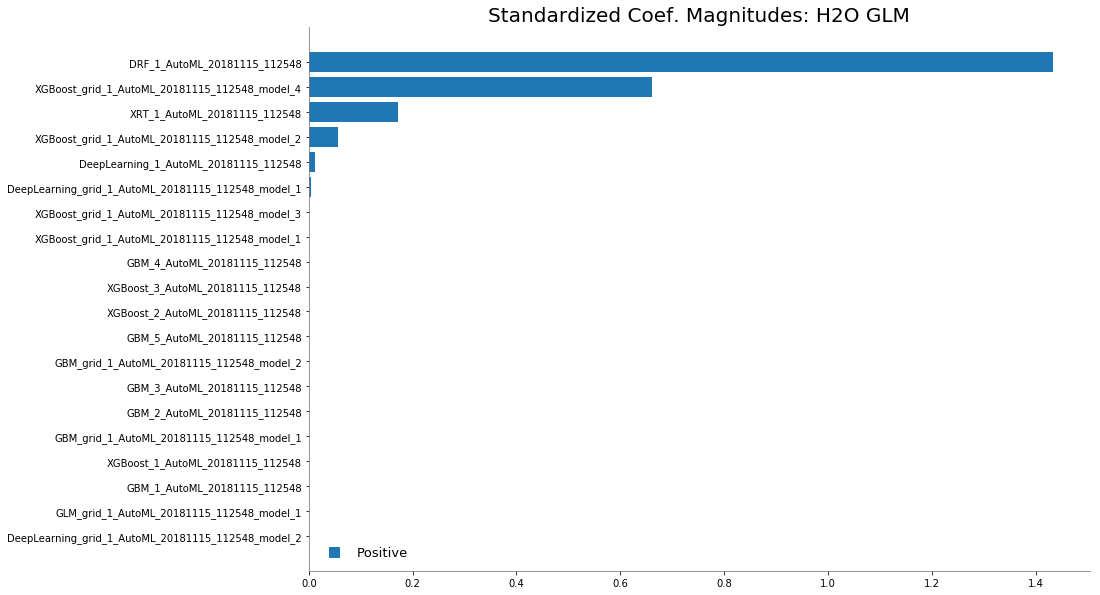

In [8]:
%matplotlib inline
metalearner.std_coef_plot()

In [10]:
aml.leader.download_mojo(path = "./product_model_bin/m20/mojo", get_genmodel_jar = True)

'/home/siemanalyst/notebooks/siem/product_model_bin/m20/mojo/StackedEnsemble_AllModels_AutoML_20181115_112548.zip'

In [3]:
sc.stop()